In [78]:
import torch
import torchvision
import torch.nn  as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch import Tensor
import os
import glob
import shutil
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## データセットの作成

In [3]:
train_vali_df = pd.read_csv("./images/train.csv", index_col=0)
test_df = pd.read_csv("./images/test.csv", index_col=0)

In [5]:
train_vali_df['class0'] = (train_vali_df['treated_t'] < 0.5) * 1
train_vali_df['class1'] = ((train_vali_df['treated_t'] >= 0.5) & (train_vali_df['treated_t'] <= 1.0)) * 1
train_vali_df['class2'] = (train_vali_df['treated_t'] > 1.0) * 1

In [7]:
test_df['class0'] = (test_df['treated_t'] < 0.5) * 1
test_df['class1'] = ((test_df['treated_t'] >= 0.5) & (test_df['treated_t'] <= 1.0)) * 1
test_df['class2'] = (test_df['treated_t'] > 1.0) * 1

In [9]:
train_df, vali_df = train_test_split(train_vali_df.copy(), test_size=0.15, train_size=0.85, shuffle=True)

In [10]:
df_train_0 = train_df.copy()[train_df['class0']==1]
df_train_1 = train_df.copy()[train_df['class1']==1]
df_train_2 = train_df.copy()[train_df['class2']==1]

df_vali_0 = vali_df.copy()[vali_df['class0']==1]
df_vali_1 = vali_df.copy()[vali_df['class1']==1]
df_vali_2 = vali_df.copy()[vali_df['class2']==1]

df_test_0 = test_df.copy()[test_df['class0']==1]
df_test_1 = test_df.copy()[test_df['class1']==1]
df_test_2 = test_df.copy()[test_df['class2']==1]

In [11]:
print("========train==========")
print(df_train_0['class0'].sum())
print(df_train_1['class1'].sum())
print(df_train_2['class2'].sum())
print("=========vali=========")
print(df_vali_0['class0'].sum())
print(df_vali_1['class1'].sum())
print(df_vali_2['class2'].sum())
print("=========test=========")
print(df_test_0['class0'].sum())
print(df_test_1['class1'].sum())
print(df_test_2['class2'].sum())

========train==========
425
423
427
=========vali=========
75
77
73
=========test=========
200
200
200


In [12]:

df_train_0_under = df_train_0.copy().sample(n=423)
df_train_1_under = df_train_1.copy().sample(n=423)
df_train_2_under = df_train_2.copy().sample(n=423)

df_vali_0_under = df_vali_0.copy().sample(n=73)
df_vali_1_under = df_vali_1.copy().sample(n=73)
df_vali_2_under = df_vali_2.copy().sample(n=73)

In [14]:
print("========train==========")
print(df_train_0_under['class0'].sum())
print(df_train_1_under['class1'].sum())
print(df_train_2_under['class2'].sum())
print("=========vali=========")
print(df_vali_0_under['class0'].sum())
print(df_vali_1_under['class1'].sum())
print(df_vali_2_under['class2'].sum())
print("=========test=========")
print(df_test_0['class0'].sum())
print(df_test_1['class1'].sum())
print(df_test_2['class2'].sum())

========train==========
423
423
423
=========vali=========
73
73
73
=========test=========
200
200
200


In [15]:
df_train_0_under.to_csv('./images/csv/train0_under.csv')
df_train_1_under.to_csv('./images/csv/train1_under.csv')
df_train_2_under.to_csv('./images/csv/train2_under.csv')

df_vali_0_under.to_csv('./images/csv/vali0_under.csv')
df_vali_1_under.to_csv('./images/csv/vali1_under.csv')
df_vali_2_under.to_csv('./images/csv/vali2_under.csv')

df_test_0.to_csv('./images/csv/test0_under.csv')
df_test_1.to_csv('./images/csv/test1_under.csv')
df_test_2.to_csv('./images/csv/test2_under.csv')

## カスタムデータセットとデータローダー

In [16]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

class CustomDataset(torch.utils.data.Dataset): 
	classes = ['0', '1', '2']
	
	def __init__(self, path_lst, img_path, transform=None):
		'''
		path_lst:
		-	class0_under.csv
		-	class1_under.csv
		-	class2_under.csv
		img_path: 画像が保存されているパス
		'''
		self.img_path = img_path
		self.transform = transform
		self.images = []
		self.labels = []
		df_0 = pd.read_csv(path_lst[0], index_col=0)
		df_1 = pd.read_csv(path_lst[1], index_col=0)
		df_2 = pd.read_csv(path_lst[2], index_col=0)
		self.images = list(df_0['img_path']) + list(df_1['img_path']) +  list(df_2['img_path'])
		self.labels = list(df_0['class0'] * 0) + list(df_1['class1'] * 1) + list(df_2['class2'] * 2) 

	def __getitem__(self, index):
		image = self.images[index]
		image = os.path.join(self.img_path, image)
		label = self.labels[index]
		with open(image, 'rb') as f:
			image = Image.open(f)
			image = image.convert('RGB')
		if self.transform is not None:
			image = self.transform(image)
		return image, label

	def __len__(self):
		return len(self.images)

In [53]:
train_path_lst = [
	'./images/csv/train0_under.csv',
	'./images/csv/train1_under.csv', 
	'./images/csv/train2_under.csv']
custom_train_dataset = CustomDataset(train_path_lst, './images/train', data_transforms)

vali_path_lst = [
	'./images/csv/vali0_under.csv',
	'./images/csv/vali1_under.csv', 
	'./images/csv/vali2_under.csv']
custom_vali_dataset = CustomDataset(vali_path_lst, './images/train', data_transforms)

test_path_lst = [
	'./images/csv/test0_under.csv',
	'./images/csv/test1_under.csv', 
	'./images/csv/test2_under.csv']
custom_test_dataset = CustomDataset(test_path_lst, './images/test', data_transforms)

In [54]:
train_loader = torch.utils.data.DataLoader(
	dataset=custom_train_dataset,
	batch_size=32,
	shuffle=True
)

vali_loader = torch.utils.data.DataLoader(
	dataset=custom_vali_dataset,
	batch_size=32,
	shuffle=False
)

test_loader = torch.utils.data.DataLoader(
	dataset=custom_test_dataset,
	batch_size=32,
	shuffle=False
)

## ネットワーク定義

In [88]:
class MC_Dropout2d(nn.modules.dropout._DropoutNd):
    def __init__(self):
        super().__init__()
    def forward(self, input:Tensor) -> Tensor:
        return F.dropout2d(input, self.p, True, self.inplace)

In [89]:
import torch
import torchvision
import torch.nn  as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class MyBasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(MyBasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = models.conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = models.conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class MyBottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(MyBottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        #mc
        #self.mcdrop1 = nn.Dropout2d()
        self.mcdrop1 = MC_Dropout2d()

        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        #mc
        self.mcdrop2 = MC_Dropout2d()

        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        #mc
        self.mcdrop3 = MC_Dropout2d()

        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        #mc
        out = self.mcdrop1(out)

        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        #mc
        out = self.mcdrop3(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        #mc
        out = self.mcdrop3(out)

        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class MyResNet(nn.Module):

    def __init__(self, block, layers, num_classes=3, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(MyResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc1 = nn.Linear(512 * block.expansion, num_classes)
        #↑純粋なResNet50
        '''
        Customize↓
        '''
        self.relu2 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(512 * block.expansion, 512)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout1 = MC_Dropout2d()
        self.fc2 = nn.Linear(512, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.2)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        '''
        Customize↑
        '''
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, MyBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, MyBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc1(x)
        '''
        custom↓
        '''
        x = self.relu2(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc3(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)


In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MyResNet(MyBottleneck, [3, 4, 6, 3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.1)

num_epoch = 10

In [81]:
state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')

In [82]:
net.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for MyResNet:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "fc3.weight", "fc3.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

## 学習

In [62]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epoch):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    net.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    net.eval()
    with torch.no_grad():
        for images, labels in vali_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(vali_loader.dataset)
        avg_val_acc = val_acc / len(vali_loader.dataset)
    print("Epoch [{}/{}], train_loss: {:4f}, val_loss: {:4f}, train_acc: {:4f}, val_acc: {:4f}".format(
        epoch+1, num_epoch, avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc
    ))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

100%|██████████| 40/40 [11:52<00:00, 17.80s/it]


Epoch [1/10], train_loss: 0.036154, test_loss: 0.036126, train_acc: 0.407407, test_acc: 0.333333


100%|██████████| 40/40 [14:52<00:00, 22.31s/it]


Epoch [2/10], train_loss: 0.032877, test_loss: 0.037149, train_acc: 0.476753, test_acc: 0.333333


100%|██████████| 40/40 [12:28<00:00, 18.71s/it]


Epoch [3/10], train_loss: 0.031722, test_loss: 0.039312, train_acc: 0.479117, test_acc: 0.333333


100%|██████████| 40/40 [16:58<00:00, 25.46s/it]


Epoch [4/10], train_loss: 0.031440, test_loss: 0.040213, train_acc: 0.505122, test_acc: 0.333333


100%|██████████| 40/40 [09:52<00:00, 14.82s/it]


Epoch [5/10], train_loss: 0.030581, test_loss: 0.033862, train_acc: 0.516942, test_acc: 0.442922


100%|██████████| 40/40 [09:38<00:00, 14.46s/it]


Epoch [6/10], train_loss: 0.030617, test_loss: 0.034718, train_acc: 0.506698, test_acc: 0.351598


100%|██████████| 40/40 [08:45<00:00, 13.15s/it]


Epoch [7/10], train_loss: 0.030116, test_loss: 0.039104, train_acc: 0.516942, test_acc: 0.369863


100%|██████████| 40/40 [09:03<00:00, 13.59s/it]


Epoch [8/10], train_loss: 0.030053, test_loss: 0.037242, train_acc: 0.519307, test_acc: 0.347032


100%|██████████| 40/40 [09:39<00:00, 14.50s/it]


Epoch [9/10], train_loss: 0.030478, test_loss: 0.038441, train_acc: 0.512214, test_acc: 0.347032


100%|██████████| 40/40 [08:49<00:00, 13.23s/it]


Epoch [10/10], train_loss: 0.029907, test_loss: 0.031913, train_acc: 0.542159, test_acc: 0.497717


In [91]:
from debuet.mytorch.utils import utils

In [92]:
net.load_state_dict(torch.load('first_mcdrop.pth'))

<All keys matched successfully>

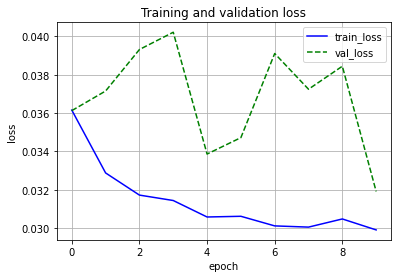

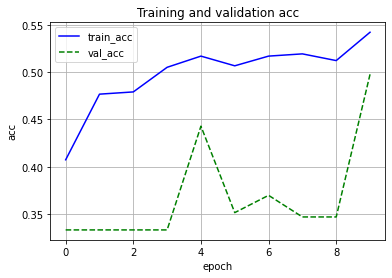

In [67]:
utils.plot_epoch_to_loss_acc(
	num_epoch, 
	train_loss_list, 
	val_loss_list, 
	train_acc_list, 
	val_acc_list
)

In [63]:
torch.save(net.state_dict(), "first_mcdrop.pth")

## モデルの評価

In [96]:
test_loader = torch.utils.data.DataLoader(
	dataset=custom_test_dataset,
	batch_size=1,
	shuffle=False
)

In [ ]:
import statistics

label_lst = []
predict_lst = []
data_uncertainty_lst = []
model_uncertainty_lst = []
softmax = nn.Softmax(dim=1)
net.eval()
for images, labels in tqdm(test_loader):
    images = images.to(device)
    class0_lst = []
    class1_lst = []
    class2_lst = []
    for i in range(10):
        output = softmax(net(images))[0]
        class0_lst.append(float(output[0]))
        class1_lst.append(float(output[1]))
        class2_lst.append(float(output[2]))
    mean_lst = [
        statistics.mean(class0_lst),
        statistics.mean(class1_lst),
        statistics.mean(class2_lst)
    ]
    max_mean = max(mean_lst)
    predict_lst.append(mean_lst.index(max_mean))
    data_uncertainty_lst.append(max_mean)
    var_lst = [
        statistics.variance(class0_lst),
        statistics.variance(class1_lst),
        statistics.variance(class2_lst)
    ]
    model_uncertainty_lst.append(sum(var_lst))
    label_lst.append(int(labels.to('cpu').detach().numpy().copy()))

print(label_lst)
print(predict_lst)
print(data_uncertainty_lst)
print(model_uncertainty_lst)

In [120]:
cnt = 0
for counter in range(len(predict_lst)):
    if predict_lst[counter] == label_lst[counter]:
        cnt += 1
print("test_acc: ", cnt / counter)

test_acc:  0.5058430717863105


In [226]:
correct_model_un = []
incorrect_model_un = []
correct_data_un = []
incorrect_data_un = []
outcome_lst = []
for i in range(len(label_lst)):
    if (label_lst[i] == predict_lst[i]):
        correct_model_un.append(model_uncertainty_lst[i])
        correct_data_un.append(data_uncertainty_lst[i])
        outcome_lst.append(1)
    else:
        incorrect_model_un.append(model_uncertainty_lst[i])
        incorrect_data_un.append(data_uncertainty_lst[i])
        outcome_lst.append(0)

In [220]:
def plot_hist_line(correct_lst, incorrect_lst, min_, max_, bandwidth):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.hist(correct_lst, alpha=0.3, label="correct")
    ax1.hist(incorrect_lst, alpha=0.3, label="error")
    ax1.set_xlabel("model uncertainty")
    ax1.set_ylabel("density")
    plt.legend()
    ax2 = ax1.twinx()
    x = np.linspace(min_, max_, 2000)[:,None]
    df_co = pd.DataFrame()
    df_co['correct'] = correct_lst
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(df_co['correct'][:,None]))
    dens1 = kde1.score_samples(x)
    ax2.plot(x, np.exp(dens1))
    df_in = pd.DataFrame()
    df_in['incorrect'] = incorrect_lst
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.array(df_in['incorrect'][:,None]))
    dens2 = kde2.score_samples(x)
    ax2.plot(x, np.exp(dens2))

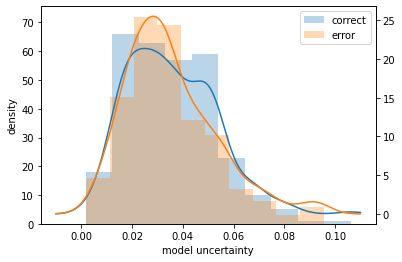

In [221]:
plot_hist_line(correct_model_un, incorrect_model_un, -0.01, 0.11, 0.005)

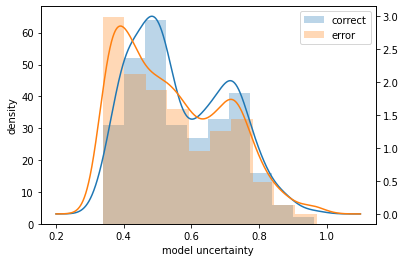

In [224]:
plot_hist_line(correct_data_un, incorrect_data_un, 0.2, 1.1, 0.035)

In [230]:
from sklearn.metrics import roc_curve, roc_auc_score
def plt_roc_auc(outcome_lst, model_uncertainty_lst, data_uncertainty_lst):
    fpr, tpr, _ = roc_curve(outcome_lst, model_uncertainty_lst)
    plt.plot(fpr, tpr, label='model uncertainty')
    plt.fill_between(fpr, tpr, 0, alpha=0.3)
    fpr, tpr, _ = roc_curve(outcome_lst, data_uncertainty_lst)
    plt.plot(fpr, tpr, label='data uncertainty')
    plt.fill_between(fpr, tpr, 0, alpha=0.3)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()
    print(f'model uncertaity AUC: {roc_auc_score(outcome_lst, model_uncertainty_lst):.4f}')
    print(f'data uncertainty AUC: {roc_auc_score(outcome_lst, data_uncertainty_lst):.4f}')

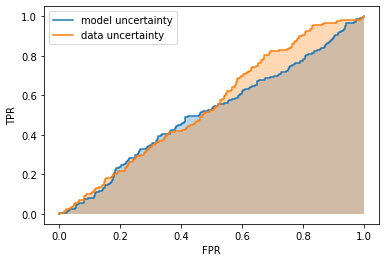

model uncertaity AUC: 0.5125
data uncertainty AUC: 0.5484


In [231]:
plt_roc_auc(outcome_lst, model_uncertainty_lst, data_uncertainty_lst)

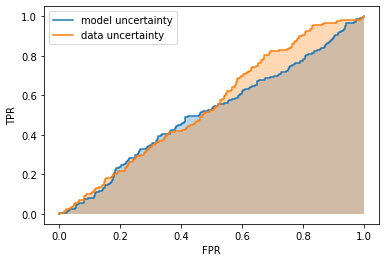

model uncertaity AUR: 0.5125
data uncertainty AUR: 0.5484


In [229]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(outcome_lst, model_uncertainty_lst)
plt.plot(fpr, tpr, label='model uncertainty')
plt.fill_between(fpr, tpr, 0, alpha=0.3)

fpr, tpr, _ = roc_curve(outcome_lst, data_uncertainty_lst)
plt.plot(fpr, tpr, label='data uncertainty')
plt.fill_between(fpr, tpr, 0, alpha=0.3)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

print(f'model uncertaity AUC: {roc_auc_score(outcome_lst, model_uncertainty_lst):.4f}')
print(f'data uncertainty AUC: {roc_auc_score(outcome_lst, data_uncertainty_lst):.4f}')

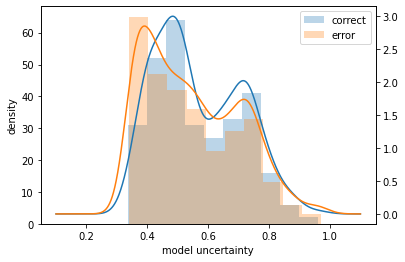

In [216]:
from sklearn.neighbors import KernelDensity

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(correct_data_un, alpha=0.3, label="correct")
ax1.hist(incorrect_data_un, alpha=0.3, label="error")
ax1.set_xlabel("model uncertainty")
ax1.set_ylabel("density")
plt.legend()
ax2 = ax1.twinx()
df_co = pd.DataFrame()
df_co['correct'] = correct_data_un
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(np.array(df_co['correct'][:,None]))
x = np.linspace(0.1,1.1, 2000)[:,None]
dens1 = kde1.score_samples(x)
ax2.plot(x, np.exp(dens1))
df_in = pd.DataFrame()
df_in['incorrect'] = incorrect_data_un
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(np.array(df_in['incorrect'][:,None]))
dens2 = kde2.score_samples(x)
ax2.plot(x, np.exp(dens2))